# Model Training
---

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import sys
sys.path.append('../scripts')
from data_utils import labels, view_img

In [279]:
# import data

# CNN data
test_cnn_X = pd.read_csv('../data/labels/test_cnn_X.csv', index_col=0)
test_cnn_y = pd.read_csv('../data/labels/test_cnn_y.csv', index_col=0)

train_cnn_X = pd.read_csv('../data/labels/train_cnn_X.csv', index_col=0)
train_cnn_y = pd.read_csv('../data/labels/train_cnn_y.csv', index_col=0)

val_cnn_X = pd.read_csv('../data/labels/val_cnn_X.csv', index_col=0)
val_cnn_y = pd.read_csv('../data/labels/val_cnn_y.csv', index_col=0)


# Tabular data
test_tab_X = pd.read_csv('../data/labels/test_tab_X.csv', index_col=0)
test_tab_y = pd.read_csv('../data/labels/test_tab_y.csv', index_col=0)

train_tab_X = pd.read_csv('../data/labels/train_tab_X.csv', index_col=0)
train_tab_y = pd.read_csv('../data/labels/train_tab_y.csv', index_col=0)

val_tab_X = pd.read_csv('../data/labels/val_tab_X.csv', index_col=0)
val_tab_y = pd.read_csv('../data/labels/val_tab_y.csv', index_col=0)

# MLP Model

In [135]:
# Convert data to torch.float32

def convert_to_float32(data):
    return torch.tensor(data.values, dtype=torch.float32)

# Convert Tabular data
test_tab_X = convert_to_float32(test_tab_X)
test_tab_y = convert_to_float32(test_tab_y)

train_tab_X = convert_to_float32(train_tab_X)
train_tab_y = convert_to_float32(train_tab_y)

val_tab_X = convert_to_float32(val_tab_X)
val_tab_y = convert_to_float32(val_tab_y)

In [136]:
# Developed a multi-label classification multi-lablel perceptron for tabular data

class MLP(nn.Module):
    def __init__(self, in_features=4, hidden1=64, hidden2=32, out_features=15):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden1)

        self.fc2 = nn.Linear(in_features=hidden1, out_features=hidden2)

        self.output = nn.Linear(in_features=hidden2, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        
        return x

model = MLP()

In [137]:
# Identified label imbalance among target variables

label_counts = train_tab_y.sum(dim=0)
print(label_counts)

tensor([ 6631.,  1381.,  2298.,  1136.,  6937.,  1161.,  1015.,   109., 11052.,
         3230., 40458.,  3841.,  1792.,   675.,  2117.])


In [138]:
# Select loss function and optimizer

num_samples = train_tab_y.shape[0]
neg_counts = num_samples - label_counts
pos_weight = neg_counts / (label_counts + 1e-8)  


criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [139]:
# Model training

epoch = 100
losses = []

for i in range(epoch):

    y_pred = model(train_tab_X)

    loss = criterion(y_pred, train_tab_y)

    losses.append(loss.detach().numpy())

    if i % 10 == 0:
        print(f'Epoch: {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0, loss: 1.284820556640625
Epoch: 10, loss: 1.1956292390823364
Epoch: 20, loss: 1.1803412437438965
Epoch: 30, loss: 1.1728942394256592
Epoch: 40, loss: 1.1681216955184937
Epoch: 50, loss: 1.164495825767517
Epoch: 60, loss: 1.1618123054504395
Epoch: 70, loss: 1.1592315435409546
Epoch: 80, loss: 1.157715082168579
Epoch: 90, loss: 1.1541155576705933


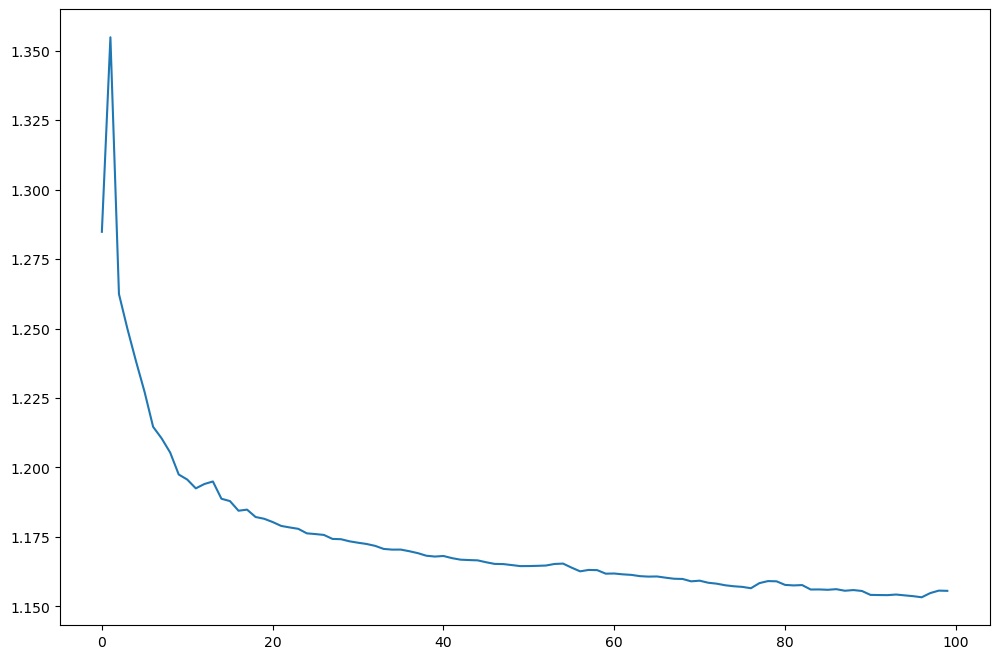

In [140]:
plt.figure(figsize=(12,8))
plt.plot(range(epoch), losses)
plt.show()

# CNN Model

In [141]:

# images need to be converted to float32, issue: current X represent file path to images not images themselves
# use ToTensor dugin transformation
""" 
# Convert CNN data
test_cnn_X = convert_to_float32(test_cnn_X)
test_cnn_y = convert_to_float32(test_cnn_y)

train_cnn_X = convert_to_float32(train_cnn_X)
train_cnn_y = convert_to_float32(train_cnn_y)

val_cnn_X = convert_to_float32(val_cnn_X)
val_cnn_y = convert_to_float32(val_cnn_y)
"""



' \n# Convert CNN data\ntest_cnn_X = convert_to_float32(test_cnn_X)\ntest_cnn_y = convert_to_float32(test_cnn_y)\n\ntrain_cnn_X = convert_to_float32(train_cnn_X)\ntrain_cnn_y = convert_to_float32(train_cnn_y)\n\nval_cnn_X = convert_to_float32(val_cnn_X)\nval_cnn_y = convert_to_float32(val_cnn_y)\n'

In [213]:
test_cnn_X

,image_path
0,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
1,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
2,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
3,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
4,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
...,...
25586,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
25587,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
25588,C:\Users\reala\.cache\kagglehub\datasets\nih-c...
25589,C:\Users\reala\.cache\kagglehub\datasets\nih-c...


In [219]:
test_cnn_y.iloc[0]

Atelectasis           0
Cardiomegaly          0
Consolidation         0
Edema                 0
Effusion              0
Emphysema             0
Fibrosis              0
Hernia                1
Infiltration          0
Mass                  0
No Finding            0
Nodule                0
Pleural_Thickening    0
Pneumonia             0
Pneumothorax          0
Name: 0, dtype: int64

In [292]:
# Initialize CNN Dataset and DataLoader

class CNNDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):

        if self.X is not None:
            return len(self.X)
        
        elif self.y is not None: 
            return len(self.y)
        
        elif self.X and self.y is not None:
            return (len(self.X), len(self.y))
        
    def __getitem__(self, idx):
        
        cols = list(self.data.columns.values)

        if "image_path" in cols:
            img_path = self.data[idx,0]
            img = Image.open(img_path).convert('L')

            if self.transform:
                img = self.transform(img)
            
            return img
        else:
            labels = self.data.iloc[idx]
            return labels


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

img_tensor = transform(x)
img_tensor

tensor([[[0.2706, 0.2275, 0.1922,  ..., 0.0706, 0.0392, 0.0000],
         [0.2667, 0.2275, 0.1922,  ..., 0.0706, 0.0392, 0.0000],
         [0.2745, 0.2275, 0.1922,  ..., 0.0667, 0.0392, 0.0000],
         ...,
         [0.1725, 0.1686, 0.1686,  ..., 0.8510, 0.9059, 0.5451],
         [0.2039, 0.1961, 0.1961,  ..., 0.8392, 0.9020, 0.5373],
         [0.2392, 0.2314, 0.2314,  ..., 0.8431, 0.9176, 0.5451]]])